# Build a self-attention Transformer model



### Building and training the model


In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,roc_curve
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
from tensorboardX import SummaryWriter

In [2]:
POS_RATING_THRESHOLD = 5

In [3]:
# Import the dataset. Use clean_review and label columns
train_dataset = pd.read_csv('drugreview/drugreview_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'rating'])

# Change columns order
train_dataset['label'] = train_dataset.rating >= POS_RATING_THRESHOLD
train_dataset = train_dataset[['clean_review', 'label']]

In [4]:
# Depict the first 5 rows of the training set
train_dataset = train_dataset.dropna()
train_dataset.head()

,clean_review,label
1,okay anxiety gotten worse past couple years po...,True
6,reading possible effects scary medicine gave l...,True
9,clonazepam effective controlling agitation pro...,True
11,experienced effects considering anorexia nervo...,True
12,i&#039;ve gianvi months skin clear didn&#039;t...,True


To fine-tune the hyperparameters we will evaluate the model on a validation set.

In [5]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('drugreview/drugreview_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
val_dataset['label'] = val_dataset.rating >= POS_RATING_THRESHOLD
val_dataset = val_dataset[['clean_review', 'label']]

In [6]:
# Depict the first 5 rows of the validation set
val_dataset = val_dataset.dropna()
val_dataset.head()

,clean_review,label
1,4yrs having nexaplon implant mental physical h...,False
4,l5 s1 lumbar herniated disc surgery weeks surg...,True
5,far lot acne clear tea tree broke decided birt...,True
6,insulin works fine trouble pen pain pen jammed...,False
7,nexplanon option work iud painful insert pills...,True


Now we will use the BatchIterator class to preprocess the text data and generate batches.

In [7]:
batch_size = 128

In [8]:
train_iterator = BatchIterator(train_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.9,
                               use_pretrained_vectors=True, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
14773/39267 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 59
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 12312/14777 of pre-trained word vectors.
2465 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [9]:
val_iterator = BatchIterator(val_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.9, use_pretrained_vectors=True, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_val.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
7720/19770 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 58
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 12475/15036 of pre-trained word vectors.
2561 vectors initialized to random numbers
Weights vectors saved into glove/weights_val.npy
Batches created


Now we will check out if the batches look correctly.

In [10]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([128, 60])
target shape:  torch.Size([128])
x_lengths shape:  torch.Size([128])


In [11]:
# Extract the maximum sequence length

max_len = 0

for batches in train_iterator:
    x_lengths = batches['x_lengths']
    if max(x_lengths) > max_len:
        max_len = int(max(x_lengths))

In [12]:
print('Maximum sequence length: {}'.format(max_len))

Maximum sequence length: 60


Let's start implementing the Transformer model.

In [13]:
class MultiHeadAttention(nn.Module):

    
    def __init__(self, dmodel, heads):
        
        super(MultiHeadAttention, self).__init__()
        
        assert dmodel % heads == 0, 'Embedding dimension is not divisible by number of heads'
            
        self.dmodel = dmodel
        self.heads = heads
        # Split dmodel (embedd dimension) into 'heads' number of chunks
        # each chunk of size key_dim will be passed to different attention head
        self.key_dim = dmodel // heads
        
        # keys, queries and values will be computed at once for all heads
        self.linear = nn.ModuleList([
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False)])
        
        self.concat = nn.Linear(self.dmodel, self.dmodel, bias=False)
        
        
    def forward(self, inputs):
   
        
        self.batch_size = inputs.size(0)
        
        assert inputs.size(2) == self.dmodel, 'Input sizes mismatch, dmodel={}, while embedd={}'\
            .format(self.dmodel, inputs.size(2))

        # Inputs shape (batch_size, seq_length, embedding_dim)        
        # Map input batch allong embedd dimension to query, key and value vectors with
        # a shape of (batch_size, heads, seq_len, key_dim (dmodel // heads)) 
        # where 'heads' dimension corresponds o different attention head
        query, key, value = [linear(x).view(self.batch_size, -1, self.heads, self.key_dim).transpose(1, 2)\
                             for linear, x in zip(self.linear, (inputs, inputs, inputs))]
        
        # Calculate the score (batch_size, heads, seq_len, seq_len)
        # for all heads at once
        score = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(self.key_dim)
        
        # Apply softmax to scores (batch_size, heads, seq_len, seq_len) 
        soft_score = F.softmax(score, dim = -1)
        
        # Multiply softmaxed score and value vector
        # value input shape (batch_size, heads, seq_len, key_dim)
        # out shape (batch_size, seq_len, dmodel (key_dim * heads))
        out = torch.matmul(soft_score, value).transpose(1, 2).contiguous()\
            .view(self.batch_size, -1, self.heads * self.key_dim)
        
        # Concatenate and linearly transform heads to the lower dimensional space
        # out shape (batch_size, seq_len, dmodel)
        out = self.concat(out)
        
        return out
        
        
class PositionalEncoding(nn.Module):
    
    
    def __init__(self, max_len, dmodel, dropout, padding_idx):
        
        super(PositionalEncoding, self).__init__()
                
        self.dropout = nn.Dropout(dropout)
        
        # Create pos_encoding, positions and dimensions matrices
        # with a shape of (max_len, dmodel)
        self.pos_encoding = torch.zeros(max_len, dmodel)
        positions = torch.repeat_interleave(torch.arange(float(max_len)).unsqueeze(1), dmodel, dim=1)
        dimensions = torch.arange(float(dmodel)).repeat(max_len, 1)
                                  
        # Calculate the encodings trigonometric function argument (max_len, dmodel)
        trig_fn_arg = positions / (torch.pow(10000, 2 * dimensions / dmodel))
               
        # Encode positions using sin function for even dimensions and
        # cos function for odd dimensions
        self.pos_encoding[:, 0::2] = torch.sin(trig_fn_arg[:, 0::2])
        self.pos_encoding[:, 1::2] = torch.cos(trig_fn_arg[:, 1::2])
        
        # Set the padding positional encoding to zero tensor
        if padding_idx:
            self.pos_encoding[padding_idx] = 0.0
        
        # Add batch dimension
        self.pos_encoding = self.pos_encoding.unsqueeze(0)
        
        
    def forward(self, embedd):
        
        
        # embedd shape (batch_size, seq_length, embedding_dim)
        # pos_encoding shape (1, max_len, dmodel = embedd_dim)
        embedd = embedd + self.pos_encoding[:, :embedd.size(1), :]
        embedd = self.dropout(embedd)
        
        # embedd shape (batch_size, seq_length, embedding_dim)
        return embedd  
    
    
class LabelSmoothingLoss(nn.Module):
    
    
    def __init__(self, output_size, label_smoothing=0):

        super(LabelSmoothingLoss, self).__init__()
        
        self.output_size = output_size
        self.label_smoothing = label_smoothing
        self.confidence = 1 - self.label_smoothing
        
        assert label_smoothing >= 0.0 and label_smoothing <= 1.0, \
        'Label smoothing parameter takes values in the range [0, 1]'

        self.criterion = nn.KLDivLoss()
        
        
    def forward(self, pred, target):
       
        
        one_hot_probs = torch.full(size=pred.size(), fill_value=self.label_smoothing/(self.output_size - 1))
       
        one_hot_probs.scatter_(1, target.unsqueeze(1), self.confidence)
            
       
        return self.criterion(pred, one_hot_probs)    


In [14]:
class TransformerBlock(nn.Module):
  
    
    def __init__(self, dmodel, ffnn_hidden_size, heads, dropout):
        
        super(TransformerBlock, self).__init__()
        
        self.attention = MultiHeadAttention(dmodel, heads)
        self.layer_norm1 = nn.LayerNorm(dmodel)
        self.layer_norm2 = nn.LayerNorm(dmodel)
        
        self.ffnn = nn.Sequential(
                nn.Linear(dmodel, ffnn_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(ffnn_hidden_size, dmodel))
        
        
    def forward(self, inputs):
               # Inputs shape (batch_size, seq_length, embedding_dim = dmodel)
        output = inputs + self.attention(inputs)            
        output = self.layer_norm1(output)            
        output = output + self.ffnn(output)            
        output = self.layer_norm2(output)

        # Output shape (batch_size, seq_length, dmodel)
        return output
        
        
class Transformer(nn.Module):
        
    def __init__(self, vocab_size, dmodel, output_size, max_len, padding_idx=0, n_layers=4,
                 ffnn_hidden_size=None, heads=8, pooling='max', dropout=0.5):
        
        super(Transformer, self).__init__()
        
        if not ffnn_hidden_size:
            ffnn_hidden_size = dmodel * 4
            
        assert pooling == 'max' or pooling == 'avg', 'Improper pooling type was passed.'
        
        self.pooling = pooling
        self.output_size = output_size
        
        self.embedding = nn.Embedding(vocab_size, dmodel)
        
        self.pos_encoding = PositionalEncoding(max_len, dmodel, dropout, padding_idx)
        
        self.tnf_blocks = nn.ModuleList()
        
        for n in range(n_layers):
            self.tnf_blocks.append(
                TransformerBlock(dmodel, ffnn_hidden_size, heads, dropout))
            
        self.tnf_blocks = nn.Sequential(*self.tnf_blocks)
            
        self.linear = nn.Linear(dmodel, output_size)
        
        
    def forward(self, inputs, input_lengths):
       
        self.batch_size = inputs.size(0)
        
        # Input dimensions (batch_size, seq_length, dmodel)
        output = self.embedding(inputs)
        output = self.pos_encoding(output)
        output = self.tnf_blocks(output)
        # Output dimensions (batch_size, seq_length, dmodel)
        
        if self.pooling == 'max':
            # Permute to the shape (batch_size, dmodel, seq_length)
            # Apply max-pooling, output dimensions (batch_size, dmodel)
            output = F.adaptive_max_pool1d(output.permute(0,2,1), (1,)).view(self.batch_size,-1)
        else:
            # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
            # Output shape: (batch_size, dmodel)
            output = torch.sum(output, dim=1) / input_lengths.view(-1,1).type(torch.FloatTensor) 
            
        output = self.linear(output)
        
        return F.log_softmax(output, dim=-1)
        
        
    def add_loss_fn(self, loss_fn):
   
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):

        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):

        self.device = device
    
    
    def train_model(self, train_iterator):

        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq, x_lengths)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):

        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq, x_lengths)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
            fone_score = f1_score(target_total.view(-1), pred_total.view(-1))
            fpr, tpr, threshold1 = roc_curve(target_total.view(-1), pred_total.view(-1))
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix, fone_score,fpr,tpr
    

In [15]:
# Initialize parameters
vocab_size = len(train_iterator.word2index)
dmodel = 64
output_size = 2
padding_idx = train_iterator.word2index['<PAD>']
n_layers = 4
ffnn_hidden_size = dmodel * 2
heads = 8
pooling = 'max'
dropout = 0.8
label_smoothing = 0.1
learning_rate = 0.001
epochs = 30

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = Transformer(vocab_size, dmodel, output_size, max_len, padding_idx, n_layers,\
                    ffnn_hidden_size, heads, pooling, dropout)

# Move the model to GPU if possible
if CUDA:
    model.cuda()
    
# Add loss function    
if label_smoothing:
    loss_fn = LabelSmoothingLoss(output_size, label_smoothing)
else:
    loss_fn = nn.NLLLoss()
    
model.add_loss_fn(loss_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Create the parameters dictionary and instantiate the tensorboardX SummaryWriter
params = {'batch_size': batch_size,
          'dmodel': dmodel,
          'n_layers': n_layers,
          'ffnn_hidden_size': ffnn_hidden_size,
          'heads': heads,
          'pooling': pooling,
          'dropout': dropout,
          'label_smoothing': label_smoothing,
          'learning_rate': learning_rate}

train_writer = SummaryWriter(comment=f' Training, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

val_writer = SummaryWriter(comment=f' Validation, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=3)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list, f1_score_list = [], [], [],[]

for epoch in range(epochs):
    
    try:
        print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))

        train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)

        train_losses_list.append(train_losses)
        train_avg_loss_list.append(train_avg_loss)
        train_accuracy_list.append(train_accuracy)

        _, eval_avg_loss, eval_accuracy, conf_matrix,fone_score,fpr,tpr = model.evaluate_model(val_iterator)

        eval_avg_loss_list.append(eval_avg_loss)
        eval_accuracy_list.append(eval_accuracy)
        conf_matrix_list.append(conf_matrix)
        f1_score_list.append(fone_score)

        print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
              .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))

        train_writer.add_scalar('Training loss', train_avg_loss, epoch)
        val_writer.add_scalar('Validation loss', eval_avg_loss, epoch)

        if early_stop.stop(eval_avg_loss, model, delta=0.003):
            break

    finally:
        train_writer.close()
        val_writer.close()



Start epoch [1/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1554. Accuracy: 0.732
Iteration: 200. Average training loss: 0.1435. Accuracy: 0.743
Iteration: 300. Average training loss: 0.1432. Accuracy: 0.746


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [1/30]: Train accuracy: 0.747. Train loss: 0.1470. Evaluation accuracy: 0.750. Evaluation loss: 0.1424

Start epoch [2/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1444. Accuracy: 0.750
Iteration: 200. Average training loss: 0.1417. Accuracy: 0.752
Iteration: 300. Average training loss: 0.1420. Accuracy: 0.753


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [2/30]: Train accuracy: 0.752. Train loss: 0.1429. Evaluation accuracy: 0.750. Evaluation loss: 0.1399

Start epoch [3/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1411. Accuracy: 0.750
Iteration: 200. Average training loss: 0.1389. Accuracy: 0.752
Iteration: 300. Average training loss: 0.1380. Accuracy: 0.752


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [3/30]: Train accuracy: 0.752. Train loss: 0.1390. Evaluation accuracy: 0.750. Evaluation loss: 0.1244

Start epoch [4/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1373. Accuracy: 0.749
Iteration: 200. Average training loss: 0.1332. Accuracy: 0.752
Iteration: 300. Average training loss: 0.1334. Accuracy: 0.754


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [4/30]: Train accuracy: 0.754. Train loss: 0.1344. Evaluation accuracy: 0.762. Evaluation loss: 0.1191

Start epoch [5/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1320. Accuracy: 0.751
Iteration: 200. Average training loss: 0.1281. Accuracy: 0.757
Iteration: 300. Average training loss: 0.1277. Accuracy: 0.759


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [5/30]: Train accuracy: 0.758. Train loss: 0.1291. Evaluation accuracy: 0.770. Evaluation loss: 0.1153

Start epoch [6/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1278. Accuracy: 0.759
Iteration: 200. Average training loss: 0.1256. Accuracy: 0.763
Iteration: 300. Average training loss: 0.1242. Accuracy: 0.765


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [6/30]: Train accuracy: 0.764. Train loss: 0.1260. Evaluation accuracy: 0.785. Evaluation loss: 0.1117

Start epoch [7/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1235. Accuracy: 0.768
Iteration: 200. Average training loss: 0.1214. Accuracy: 0.772
Iteration: 300. Average training loss: 0.1218. Accuracy: 0.772


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [7/30]: Train accuracy: 0.770. Train loss: 0.1226. Evaluation accuracy: 0.785. Evaluation loss: 0.1104

Start epoch [8/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1200. Accuracy: 0.774
Iteration: 200. Average training loss: 0.1188. Accuracy: 0.776
Iteration: 300. Average training loss: 0.1190. Accuracy: 0.776


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [8/30]: Train accuracy: 0.776. Train loss: 0.1195. Evaluation accuracy: 0.802. Evaluation loss: 0.1066

Start epoch [9/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1185. Accuracy: 0.779
Iteration: 200. Average training loss: 0.1175. Accuracy: 0.780
Iteration: 300. Average training loss: 0.1165. Accuracy: 0.781


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [9/30]: Train accuracy: 0.781. Train loss: 0.1173. Evaluation accuracy: 0.805. Evaluation loss: 0.1040

Start epoch [10/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1154. Accuracy: 0.786
Iteration: 200. Average training loss: 0.1152. Accuracy: 0.785
Iteration: 300. Average training loss: 0.1158. Accuracy: 0.784


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [10/30]: Train accuracy: 0.783. Train loss: 0.1155. Evaluation accuracy: 0.807. Evaluation loss: 0.1066

Start epoch [11/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1127. Accuracy: 0.789
Iteration: 200. Average training loss: 0.1107. Accuracy: 0.791
Iteration: 300. Average training loss: 0.1113. Accuracy: 0.791


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [11/30]: Train accuracy: 0.790. Train loss: 0.1118. Evaluation accuracy: 0.811. Evaluation loss: 0.1040

Start epoch [12/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1088. Accuracy: 0.799
Iteration: 200. Average training loss: 0.1094. Accuracy: 0.797
Iteration: 300. Average training loss: 0.1103. Accuracy: 0.797


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [12/30]: Train accuracy: 0.796. Train loss: 0.1097. Evaluation accuracy: 0.816. Evaluation loss: 0.0998

Start epoch [13/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1086. Accuracy: 0.796
Iteration: 200. Average training loss: 0.1088. Accuracy: 0.795
Iteration: 300. Average training loss: 0.1091. Accuracy: 0.795


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [13/30]: Train accuracy: 0.795. Train loss: 0.1092. Evaluation accuracy: 0.816. Evaluation loss: 0.1000

Start epoch [14/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1076. Accuracy: 0.801
Iteration: 200. Average training loss: 0.1066. Accuracy: 0.801
Iteration: 300. Average training loss: 0.1062. Accuracy: 0.801


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [14/30]: Train accuracy: 0.801. Train loss: 0.1071. Evaluation accuracy: 0.820. Evaluation loss: 0.0995

Start epoch [15/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1063. Accuracy: 0.804
Iteration: 200. Average training loss: 0.1043. Accuracy: 0.807
Iteration: 300. Average training loss: 0.1065. Accuracy: 0.804


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [15/30]: Train accuracy: 0.803. Train loss: 0.1058. Evaluation accuracy: 0.820. Evaluation loss: 0.0997

Start epoch [16/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1038. Accuracy: 0.807
Iteration: 200. Average training loss: 0.1043. Accuracy: 0.807
Iteration: 300. Average training loss: 0.1048. Accuracy: 0.806


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [16/30]: Train accuracy: 0.806. Train loss: 0.1045. Evaluation accuracy: 0.821. Evaluation loss: 0.0993

Start epoch [17/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1024. Accuracy: 0.814
Iteration: 200. Average training loss: 0.1022. Accuracy: 0.814
Iteration: 300. Average training loss: 0.1033. Accuracy: 0.812


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [17/30]: Train accuracy: 0.811. Train loss: 0.1029. Evaluation accuracy: 0.819. Evaluation loss: 0.0986

Start epoch [18/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1022. Accuracy: 0.810
Iteration: 200. Average training loss: 0.1010. Accuracy: 0.814
Iteration: 300. Average training loss: 0.1013. Accuracy: 0.814


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [18/30]: Train accuracy: 0.813. Train loss: 0.1019. Evaluation accuracy: 0.824. Evaluation loss: 0.0987

Start epoch [19/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1011. Accuracy: 0.813
Iteration: 200. Average training loss: 0.1004. Accuracy: 0.814
Iteration: 300. Average training loss: 0.0993. Accuracy: 0.815


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [19/30]: Train accuracy: 0.814. Train loss: 0.1006. Evaluation accuracy: 0.824. Evaluation loss: 0.0967

Start epoch [20/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1007. Accuracy: 0.814
Iteration: 200. Average training loss: 0.1002. Accuracy: 0.813
Iteration: 300. Average training loss: 0.0995. Accuracy: 0.814


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [20/30]: Train accuracy: 0.814. Train loss: 0.1004. Evaluation accuracy: 0.826. Evaluation loss: 0.0977

Start epoch [21/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1005. Accuracy: 0.816
Iteration: 200. Average training loss: 0.0994. Accuracy: 0.816
Iteration: 300. Average training loss: 0.0991. Accuracy: 0.816


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [21/30]: Train accuracy: 0.816. Train loss: 0.0997. Evaluation accuracy: 0.824. Evaluation loss: 0.0973

Start epoch [22/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0995. Accuracy: 0.818
Iteration: 200. Average training loss: 0.0968. Accuracy: 0.822
Iteration: 300. Average training loss: 0.0975. Accuracy: 0.821


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [22/30]: Train accuracy: 0.821. Train loss: 0.0980. Evaluation accuracy: 0.826. Evaluation loss: 0.0965

Start epoch [23/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0970. Accuracy: 0.821
Iteration: 200. Average training loss: 0.0972. Accuracy: 0.822
Iteration: 300. Average training loss: 0.0988. Accuracy: 0.820


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [23/30]: Train accuracy: 0.819. Train loss: 0.0979. Evaluation accuracy: 0.826. Evaluation loss: 0.0967

Start epoch [24/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0968. Accuracy: 0.820
Iteration: 200. Average training loss: 0.0972. Accuracy: 0.822
Iteration: 300. Average training loss: 0.0963. Accuracy: 0.821


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [24/30]: Train accuracy: 0.821. Train loss: 0.0971. Evaluation accuracy: 0.830. Evaluation loss: 0.0962

Start epoch [25/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0956. Accuracy: 0.824
Iteration: 200. Average training loss: 0.0961. Accuracy: 0.824
Iteration: 300. Average training loss: 0.0967. Accuracy: 0.823


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [25/30]: Train accuracy: 0.823. Train loss: 0.0965. Evaluation accuracy: 0.826. Evaluation loss: 0.0957

Start epoch [26/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0954. Accuracy: 0.825
Iteration: 200. Average training loss: 0.0950. Accuracy: 0.826
Iteration: 300. Average training loss: 0.0949. Accuracy: 0.826


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [26/30]: Train accuracy: 0.825. Train loss: 0.0955. Evaluation accuracy: 0.829. Evaluation loss: 0.0976

Start epoch [27/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0944. Accuracy: 0.827
Iteration: 200. Average training loss: 0.0949. Accuracy: 0.827
Iteration: 300. Average training loss: 0.0944. Accuracy: 0.827


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [27/30]: Train accuracy: 0.826. Train loss: 0.0948. Evaluation accuracy: 0.829. Evaluation loss: 0.0968

Start epoch [28/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0947. Accuracy: 0.825
Iteration: 200. Average training loss: 0.0964. Accuracy: 0.825
Iteration: 300. Average training loss: 0.0947. Accuracy: 0.825


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [28/30]: Train accuracy: 0.825. Train loss: 0.0955. Evaluation accuracy: 0.830. Evaluation loss: 0.0960

Training stoped by EarlyStopping


In [16]:
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])
print("f1 score:", np.mean(f1_score_list))

f1 score: 0.8809379625718277


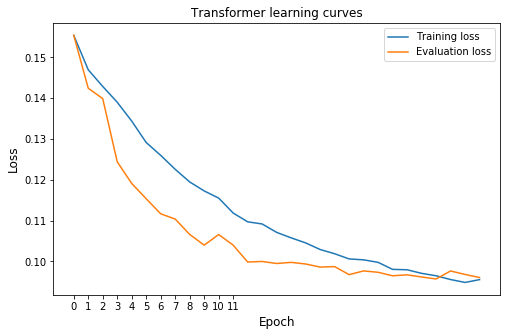

In [17]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('Transformer learning curves')
plt.xticks(ticks=range(12))
plt.legend()
plt.show()

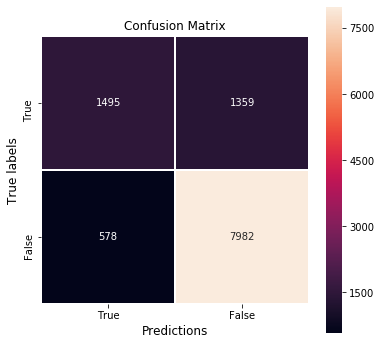

In [18]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

### The generalization error

In [19]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('drugreview/drugreview_feat_clean/test_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
test_dataset['label'] = test_dataset.rating >= POS_RATING_THRESHOLD
test_dataset = test_dataset[['clean_review', 'label']]

In [20]:
test_dataset = test_dataset.dropna()
test_dataset.head()

,clean_review,label
0,i&#039;ve tried antidepressants years citalopr...,True
1,son crohn&#039;s disease asacol complaints sho...,True
2,quick reduction symptoms,True
3,contrave combines drugs alcohol smoking opioid...,True
4,birth control cycle reading reviews type simil...,True


In [21]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=True, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
15210/40911 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 59
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 13890/17168 of pre-trained word vectors.
3278 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [22]:
_, test_avg_loss, test_accuracy, test_conf_matrix,fone_score,fpr,tpr = model.evaluate_model(test_iterator)

Evaluation:   0%|          | 0/189 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0925. Accuracy: 0.84


In [23]:
print('Test accuracy: {:.3f}. Test error: {:.3f}, Test f1: {:.3f}'.format(test_accuracy, test_avg_loss, fone_score))

Test accuracy: 0.840. Test error: 0.093, Test f1: 0.898


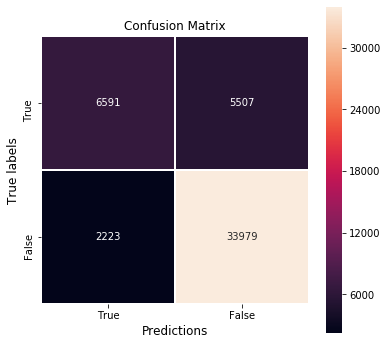

In [24]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

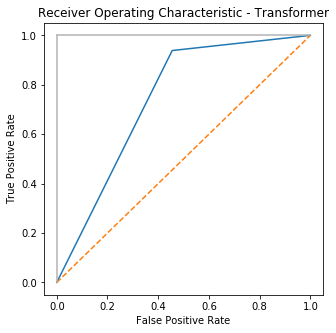

In [25]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Transformer')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()